# Figure 6a - Hourly Boxplots (Spring)

## 1 - Import Necessary Modules

In [1]:
import cartopy 
import cartopy.io.shapereader as shpreader 
import cartopy.io.shapereader as Reader 
import geopandas as gpd
import matplotlib.pyplot as plt 
import numpy as np 
import proplot as plot
import proplot
import salem
import xarray as xr 

from cartopy.feature import ShapelyFeature 
from glob import glob
from mpl_toolkits.axes_grid1.inset_locator import inset_axes 
from netCDF4 import Dataset 
from shapely.geometry import mapping
from wrf import xy_to_ll 

# warnings
import warnings
warnings.filterwarnings('ignore')

# 2. Open Pandas DataFrame

In [2]:
path_prec = r'\datasets\ankara_P_tümveri_0918.xlsx'
dsp = pd.read_excel(path_prec, sheet_name='ankara_1318_p')

# 3. Station Informations

In [3]:
station_detail = {   '17130': [39.9727, 32.8637, 'Ankara Bölge'],
                     '17134': [39.8032, 32.8434, 'Ufuk Danışment'],
                     #'17137': [39.7985, 32.9716, 'Elmadağ Radar'],
                     '17651' : [39.1525, 32.1283, 'Polatlı Tigem'],
                     '17664' : [40.4729, 32.6441, 'Kızılcahamam'],
                     '17679' : [40.1733, 31.332, 'Nallıhan'],
                     '17680' : [40.1608, 31.9172, 'Beypazarı'],
                     '17715' : [39.92, 33.2125, 'Elmadağ Barutsan Fabrikası'],
                     '17728' : [39.5834, 32.1624, 'Polatlı'],
                     '17729' : [39.5546, 33.1089, 'Bala'],
                     '17731' : [38.9539, 33.4218, 'Şereflikoçhisar'],
                     '17733' : [39.613, 32.672, 'Haymana Tarım'],
                     '17759' : [39.7414, 32.38, 'Temelli'],
                     '17987' : [40.0386, 33.2908, 'Yeşildere'],
                     '18045' : [40.03, 32.2345, 'Ayaş'],
                     '18046' : [39.9075, 32.8494, 'TBMM Bahçesi'],
                     '18072' : [40.0878, 32.8111, 'Bağlum'],
                     '18073' : [40.2725, 32.6897, 'Kurtboğazı Barajı'],
                     '18074' : [39.9194, 32.9944, 'Bayındır Barajı'],
                     '18075' : [40.4839, 32.4608, 'Çamlıdere Orman İşletme Müdürlüğü'],
                     '18076' : [40.0947, 33.4133, 'Kalecik DSİ'],
                     '18077' : [40.2111, 32.2472, 'Güdül Gençlik Spor'],
                     '18078' : [39.5578, 31.9019, 'Acıkır'],
                     '18240' : [40.1408, 33.1081, 'Akyurt'],
                     '18241' : [40.5983, 32.5033, 'Çamkoru'],
                     '18242' : [40.2867, 33.0108, 'Çubuk'],
                     '18243' : [40.0317, 32.8933, 'Pursaklar'],
                     '18244' : [39.9986, 32.5814, 'Sincan'],
                     '18250' : [39.9725, 32.8639, '9. Ankara Bölge'],
                     '18256' : [39.8572, 32.8219, 'Çaldağ'],
                     '18257' : [39.4356, 32.5153, 'Haymana'],
                     '18903' : [40.0761, 32.6075, 'Sarayköy Toprak']}

ankara_extent_lat = [38.85, 40.63] #lat1,lat2
ankara_extent_lon = [31.3, 33.565] #lon1,lon2

# 4. Function to Prepare Observation Dataset Pandas Dataframe

In [4]:
def prepare_obs_event_dataset(data, start, end):
    """
    data: Pandas Data
    start: desired start date (e.g., '2009-01-01 00')
    end: desired end date
    """
    data_copy = data.copy(deep=True)
    data_start = str(data['year'].iloc[0]) + str(data['month'].iloc[0]) + str(data['day'].iloc[0]) + str(data['hour'].iloc[0])
    data_end = str(data['year'].iloc[-1]) + str(data['month'].iloc[-1]) + str(data['day'].iloc[-1]) + str(data['hour'].iloc[-1])
    data_start = pd.to_datetime(int(data_start), format='%Y%m%d%H')
    data_end = pd.to_datetime(int(data_end), format='%Y%m%d%H')

    data_copy.index = pd.date_range(data_start, data_end, freq='1H') #set datetime index
    del data_copy['year'], data_copy['month'], data_copy['day'], data_copy['hour']    
    data_copy = data_copy.loc[start : end]
    return data_copy

# 5. Function to Imerg and WRF Extract Hourly Point Values

In [5]:
def read_netcdfs(files, dim):
    # glob expands paths with * to a list of files, like the unix shell
    paths = sorted(glob(files))
    datasets = []
    for p in paths:
        nd = xr.open_dataset(p)
        datasets.append(nd)
    combined = xr.concat(datasets, dim)
    return combined

# 6. Open WRF datasets

In [6]:
imerg_30min = read_netcdfs(r'\datasets\*20140505*', dim='time')

In [7]:
#thompson
wrf_data = salem.open_wrf_dataset(r'\spring_datasets\ankara_thompson_urban\wrfout_d03_2014-05-04_00_00_00') 
wrf_data_addit = Dataset(r'\spring_datasets\ankara_thompson_urban\wrfout_d03_2014-05-04_00_00_00')
#lin
wrf2_data = salem.open_wrf_dataset(r'\spring_datasets\ankara_lin_urban\wrfout_d03_2014-05-04_00_00_00')
wrf2_data_addit = Dataset(r'\spring_datasets\ankara_lin_urban\wrfout_d03_2014-05-04_00_00_00')
#wsm6
wrf3_data = salem.open_wrf_dataset(r'\spring_datasets\ankara_wsm6_urban\wrfout_d03_2014-05-04_00_00_00')
wrf3_data_addit = Dataset(r'\spring_datasets\ankara_wsm6_urban\wrfout_d03_2014-05-04_00_00_00')

# 7. Function to Get Point Data From Spatial Data

In [8]:
def hourly_points_from_spatial_data(data, station_details, data_addit=False, imerg=True, wrf=False, start=False, end=False):
    """
    data: Imerg half-hourly raw dataset starting from 00UTC or WRF dataset opened with Salem 
    station_details: Dictionary for the details of 
                     the observation number and lat-lons (e.g., {'17130': [lat,lon]})
    """
    data_station_locs = []
    if imerg:
        if start and end:
            data_start = start
            data_end = end
            data_updated = data['IRprecipitation'].sel(time=slice(start,end)) / 2 #remember imerg dataset half hourly detail
        else:   
            data_start = str(data['time'][0].values)
            data_end = str(data['time'][-1].values)
            data_updated = data['IRprecipitation'] / 2 #remember imerg dataset half hourly detail
        data_hourly = data_updated.resample(time='1H').sum() #half hourly to hourly values
        for i in station_details: #loop over station details to extract corresponding point values from the dataset
            data_station_locs.append(data_hourly.sel(lat=station_details[str(i)][0], #use nearest lat and lon 
                                                     lon=station_details[str(i)][1], method='nearest').values)
        
    if wrf:
        data_addit = data_addit
        if start and end:
            data_start = start
            data_end = end
            data_updated = data['PRCP'].sel(time=slice(start, end))
        else:
            data_start = str(data['PRCP'].time[0].values)
            data_end = str(data['PRCP'].time[-1].values)
            data_updated = data['PRCP'].sel(time=slice(data_start,
                                                       data_end))
        for i in station_detail:
            x,y = ll_to_xy(data_addit, station_detail[i][0], station_detail[i][1])
            data_station_locs.append(data_updated.isel(south_north=y, west_east=x).values)
        data_station_locs = np.array(data_station_locs)
            
    data_station_locs = pd.DataFrame(np.array(data_station_locs).transpose(), columns=[i for i in station_details])
    data_station_locs.index = pd.date_range(data_start, data_end, freq='1H') #set datetime index
    return data_station_locs

# 8. Turn spatial data into point data

In [9]:
obs_pandas = prepare_obs_event_dataset(dsp, '2014-05-05 00', '2014-05-05 23')
del obs_pandas[17725] #Has NaN values ; useless
del obs_pandas[17137] #Elmadağ Radar outlier in WRF

In [10]:
wrf1_pandas = hourly_points_from_spatial_data(wrf_data, station_detail, data_addit=wrf_data_addit, imerg=False, wrf=True,
                                start='2014-05-05T00', end='2014-05-05T23')
wrf2_pandas = hourly_points_from_spatial_data(wrf2_data, station_detail, data_addit=wrf_data_addit, imerg=False, wrf=True,
                                start='2014-05-05T00', end='2014-05-05T23')
wrf3_pandas = hourly_points_from_spatial_data(wrf3_data, station_detail, data_addit=wrf_data_addit, imerg=False, wrf=True,
                                start='2014-05-05T00', end='2014-05-05T23')

In [11]:
imerg_pandas = hourly_points_from_spatial_data(imerg_30min, station_detail, start='2014-05-05T00', end='2014-05-05T23')

In [12]:
#additional calculations
ensemble_wrf_pandas = (wrf1_pandas + wrf2_pandas + wrf3_pandas)/3 #get wrf ensemble mean

#calculate daily totals for each station point
obs_daily_pandas = obs_pandas.sum()
imerg_daily_pandas = imerg_pandas.sum()
ensemble_wrf_daily_pandas = ensemble_wrf_pandas.sum()
wrf1_daily_pandas = wrf1_pandas.sum()
wrf2_daily_pandas = wrf2_pandas.sum()
wrf3_daily_pandas = wrf3_pandas.sum()

In [13]:
obs_daily_pandas.index = [i for i in range(len(station_detail))]
imerg_daily_pandas.index = [i for i in range(len(station_detail))]
ensemble_wrf_daily_pandas.index = [i for i in range(len(station_detail))]
wrf1_daily_pandas.index = [i for i in range(len(station_detail))]
wrf2_daily_pandas.index = [i for i in range(len(station_detail))]
wrf3_daily_pandas.index = [i for i in range(len(station_detail))]

# 9. Boxplot

C:\Users\User\anaconda3\envs\berkay\lib\site-packages\proplot\figure.py:94: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)
C:\Users\User\anaconda3\envs\berkay\lib\site-packages\proplot\figure.py:94: MatplotlibDeprecationWarning: 
The 'progressive' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'progressive': ...} instead. If any parameter follows 'progressive', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)


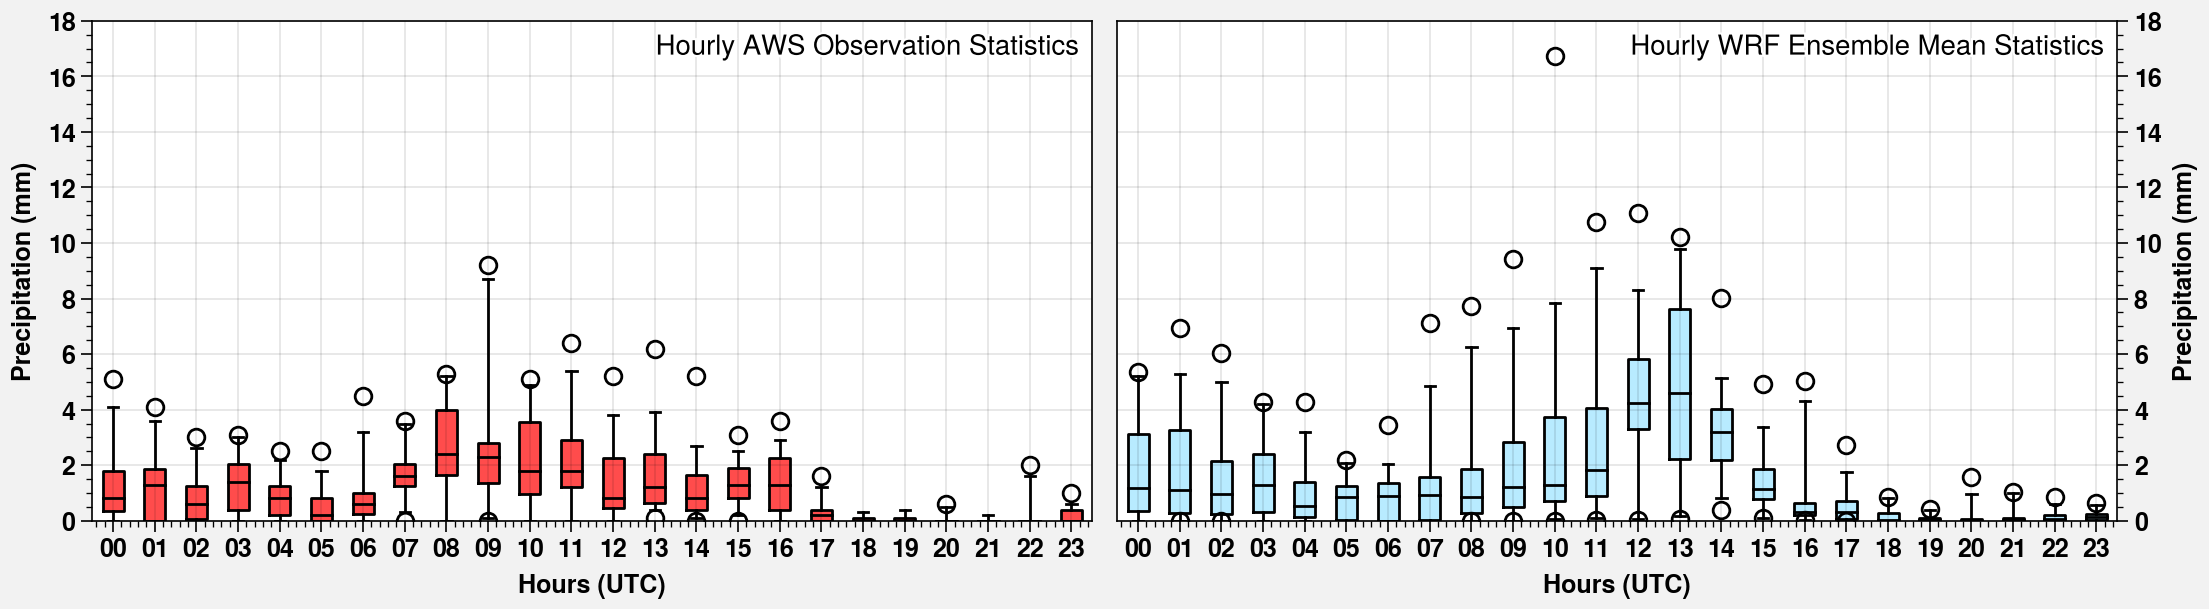

In [17]:
fig_array = [[1,1,2,2]]
fig, axs = plot.subplots(fig_array, 
                         aspect=2, axwidth=5,
                          hratios=(1), includepanels=True, share=0)

#urban olan istasyonların bar plotlarını farklı renge boya belli olsun
box_plot_colors = ['sky blue', 'seafoam green']
box_plot_datas = [obs_pandas, ensemble_wrf_pandas]
box_plot_ids = [0]
box_inner_titles = ['Hourly Observation Statistics', 'Hourly Ensemble Mean Statistics']
hours = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
         '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
         '22', '23', '24']

axs[0].boxplot(box_plot_datas[0].transpose(), lw=1, marker='o', fillcolor='#f00',
                    medianlw=1, mediancolor='k', whis=(1,99))
axs[0].format(ylim=(0,18), ylabel='Precipitation (mm)', xlabel='Hours (UTC)', 
                    xlocator=(range(0, 25, 1)), xformatter=[j for j in hours],
                    axeslabelweight='bold', ticklabelweight='bold', urtitle='Hourly AWS Observation Statistics')

axs[1].boxplot(box_plot_datas[1].transpose(), lw=1, marker='o', fillcolor='#9be3ff',
                    medianlw=1, mediancolor='k', whis=(1,99))
axs[1].format(ylim=(0,18), ylabel='Precipitation (mm)', xlabel='Hours (UTC)', 
                    xlocator=(range(0, 25, 1)), xformatter=[j for j in hours],
              ytickloc='right', yticklabelloc='right',
                    axeslabelweight='bold', ticklabelweight='bold', urtitle='Hourly WRF Ensemble Mean Statistics')


#axs[1].stem(obs_daily_pandas, linefmt='k-')
#axs[1].format(xlocator=[i for i in range(0,len(station_detail))])
plt.savefig(r'pictures/figure6a.jpeg',
            bbox_inches='tight', optimize=True, progressive=True, dpi=500)